In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Ссылка для скачивания датасета
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv

In [37]:
path = "olist_order_reviews_dataset.csv.zip"

df = pd.read_csv(path, compression='zip', nrows=100000)

print(df.head())
print(df.shape)


                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3           

In [38]:
print(df.shape)
print(df.columns)

print(df.isnull().sum())


(99224, 7)
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


In [39]:
df_text = df.dropna(subset=['review_comment_message', 'review_comment_title'], how='all').copy()

df_text.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01


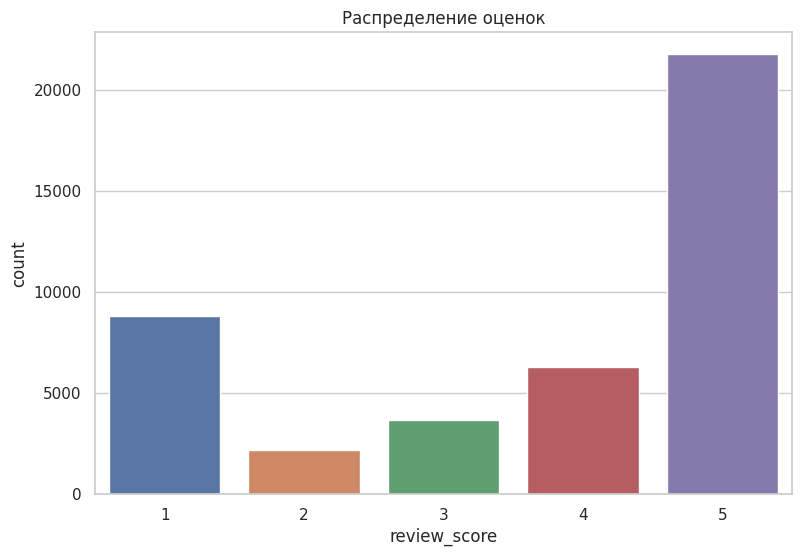

In [40]:
plt.figure(figsize=(9,6))
sns.countplot(x='review_score', data=df_text, hue='review_score', palette='deep', legend=False)
plt.title('Распределение оценок')
plt.show()



In [55]:
df_text['text'] = df_text['review_comment_title'].fillna('') + ' ' + df_text['review_comment_message'].fillna('')
df_text['text'] = df_text['text'].str.strip()


In [57]:
print(df_text.iloc[[18]]['text'])
df_text.head(15)

43    Entrega perfeita Muito bom. muito cheiroso.
Name: text, dtype: object


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa."
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok..."
16,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18 00:00:00,2018-01-20 21:25:45,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E..."
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,Não chegou meu produto Péssimo
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,Ótimo Loja nota 10
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5,NaN,obrigado pela atençao amim dispensada,2017-12-01 00:00:00,2017-12-09 22:58:58,obrigado pela atençao amim dispensada
27,fe3db7c069d694bab50cc43463f91608,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,NaN,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23 00:00:00,2018-04-01 00:27:51,A compra foi realizada facilmente.\r\nA entreg...


In [58]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=91f9ed2e353a9865d59f2f3f84c4fb42cad9938df43f786c4f7ec3adc73e577c
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [59]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"


In [60]:
df_text['lang'] = df_text['text'].apply(detect_lang)

print(df_text['lang'].value_counts())


lang
pt       37047
it        1493
es         808
ro         468
sk         458
lt         410
en         324
de         323
error      262
hr         169
ca         153
af         106
sl         101
fi          83
hu          61
so          60
nl          47
fr          43
sw          37
sv          31
id          31
vi          30
tl          23
et          20
pl          19
no          18
lv          16
da          16
cy          15
tr          15
sq          12
cs           7
Name: count, dtype: int64


In [70]:
df_text = df_text[df_text['lang'] == 'pt'].copy()

print(df_text.shape)
print(df_text[['text', 'lang']].head())

(37047, 9)
                                                 text lang
3               Recebi bem antes do prazo estipulado.   pt
4   Parabéns lojas lannister adorei comprar pela I...   pt
9   recomendo aparelho eficiente. no site a marca ...   pt
12        Mas um pouco ,travando...pelo valor ta Boa.   pt
15  Super recomendo Vendedor confiável, produto ok...   pt


In [71]:
!pip install spacy
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [95]:
import spacy

nlp = spacy.load('pt_core_news_sm')

In [96]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
import re
import string
def preprocess(text):
    if pd.isnull(text):
        return []

    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\d+', '', text)

    doc = nlp(text)

    tokens = [token.text for token in doc if not token.is_space]
    tokens = [t for t in tokens if t.strip()]
    return tokens


In [98]:
df_text['tokens'] = df_text['text'].apply(preprocess)
df_text[['text', 'tokens']].head()


,text,tokens
3,Recebi bem antes do prazo estipulado.,"[recebi, bem, antes, do, prazo, estipulado]"
4,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ..."
9,recomendo aparelho eficiente. no site a marca ...,"[recomendo, aparelho, eficiente, no, site, a, ..."
12,"Mas um pouco ,travando...pelo valor ta Boa.","[mas, um, pouco, travando, pelo, valor, ta, boa]"
15,"Super recomendo Vendedor confiável, produto ok...","[super, recomendo, vendedor, confiável, produt..."


In [99]:
df_text['clean_text'] = df_text['tokens'].apply(lambda x: ' '.join(x))
df_text.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text,lang,tokens,clean_text,sentiment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,pt,"[recebi, bem, antes, do, prazo, estipulado]",recebi bem antes do prazo estipulado,positive
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,pt,"[parabéns, lojas, lannister, adorei, comprar, ...",parabéns lojas lannister adorei comprar pela i...,positive
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,pt,"[recomendo, aparelho, eficiente, no, site, a, ...",recomendo aparelho eficiente no site a marca d...,positive
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.",pt,"[mas, um, pouco, travando, pelo, valor, ta, boa]",mas um pouco travando pelo valor ta boa,positive
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...",pt,"[super, recomendo, vendedor, confiável, produt...",super recomendo vendedor confiável produto ok ...,positive


In [111]:
def get_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'
df_text['label'] = df_text['review_score'].apply(get_sentiment)

In [112]:
df_text.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text,lang,tokens,clean_text,sentiment,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,pt,"[recebi, bem, antes, do, prazo, estipulado]",recebi bem antes do prazo estipulado,positive,positive
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,pt,"[parabéns, lojas, lannister, adorei, comprar, ...",parabéns lojas lannister adorei comprar pela i...,positive,positive
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,pt,"[recomendo, aparelho, eficiente, no, site, a, ...",recomendo aparelho eficiente no site a marca d...,positive,positive
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.",pt,"[mas, um, pouco, travando, pelo, valor, ta, boa]",mas um pouco travando pelo valor ta boa,positive,positive
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...",pt,"[super, recomendo, vendedor, confiável, produt...",super recomendo vendedor confiável produto ok ...,positive,positive


In [113]:
print(df_text['label'].value_counts())
df_text[['text', 'clean_text', 'review_score', 'label']].head()

label
positive    23177
negative    10598
neutral      3272
Name: count, dtype: int64


,text,clean_text,review_score,label
3,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado,5,positive
4,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar pela i...,5,positive
9,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente no site a marca d...,4,positive
12,"Mas um pouco ,travando...pelo valor ta Boa.",mas um pouco travando pelo valor ta boa,4,positive
15,"Super recomendo Vendedor confiável, produto ok...",super recomendo vendedor confiável produto ok ...,5,positive


In [104]:
df_text['clean_text'].to_csv(
    "FastText_corpus.txt",
    index=False,
    header=False,
    encoding="utf-8"
)

In [107]:
!pip install fasttext
import fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498211 sha256=89e6fd9dfd3dfe9bc27c112eddf3137edb4bbd4252d3901e53880f055fa606f7
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [108]:
model = fasttext.train_unsupervised(
    input="FastText_corpus.txt",
    model="skipgram",
    dim=100,
    epoch=30,
    lr=0.05,
    ws=5,
    minn=3,
    maxn=6,
    minCount=3,
    neg=10,
    bucket=2000000,
    thread=4
)

In [116]:
X = np.array([model.get_sentence_vector(text) for text in df_text['clean_text']])
y = df_text['label'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (37047, 100)
y shape: (37047,)


In [156]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [158]:
clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    class_weight='balanced'  # если классы несбалансированы
)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [159]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.752361673414305
              precision    recall  f1-score   support

    negative       0.80      0.75      0.78      2120
     neutral       0.21      0.54      0.31       654
    positive       0.96      0.78      0.86      4636

    accuracy                           0.75      7410
   macro avg       0.66      0.69      0.65      7410
weighted avg       0.85      0.75      0.79      7410



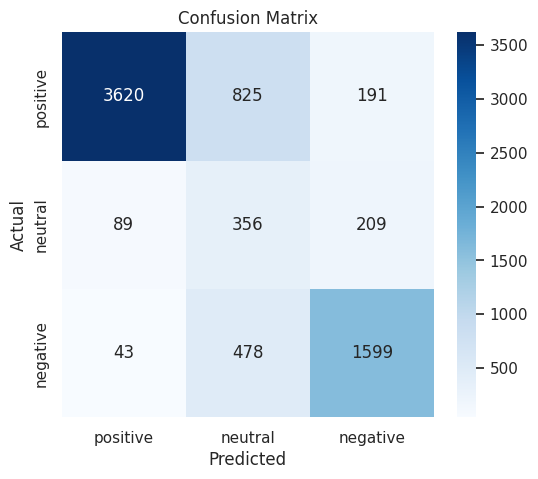

In [160]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

In [162]:
!pip install catboost
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [163]:
from collections import Counter
# считаем количество каждого класса
counter = Counter(y_train)
total = sum(counter.values())

# делаем так, чтобы редкие классы имели больший вес
class_weights = {cls: total/count for cls, count in counter.items()}
print(class_weights)


{'negative': 3.4957537154989384, 'positive': 1.5984574726282292, 'neutral': 11.320473644003055}


In [164]:
from catboost import CatBoostClassifier
clf_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=50,
    class_weights=class_weights
  )
clf_cb.fit(X_train, y_train)


0:	learn: 1.0503911	total: 207ms	remaining: 1m 43s
50:	learn: 0.6784140	total: 5.41s	remaining: 47.6s
100:	learn: 0.6260772	total: 10.2s	remaining: 40.3s
150:	learn: 0.5864033	total: 15.8s	remaining: 36.5s
200:	learn: 0.5505178	total: 20.5s	remaining: 30.5s
250:	learn: 0.5207870	total: 26s	remaining: 25.8s
300:	learn: 0.4934370	total: 30.8s	remaining: 20.3s
350:	learn: 0.4687722	total: 35.8s	remaining: 15.2s
400:	learn: 0.4471592	total: 41.1s	remaining: 10.1s
450:	learn: 0.4271195	total: 45.7s	remaining: 4.97s
499:	learn: 0.4084439	total: 51.3s	remaining: 0us


In [167]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_cb = clf_cb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))


Accuracy: 0.7898785425101215
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2120
     neutral       0.25      0.45      0.32       654
    positive       0.96      0.83      0.89      4636

    accuracy                           0.79      7410
   macro avg       0.66      0.70      0.67      7410
weighted avg       0.84      0.79      0.81      7410



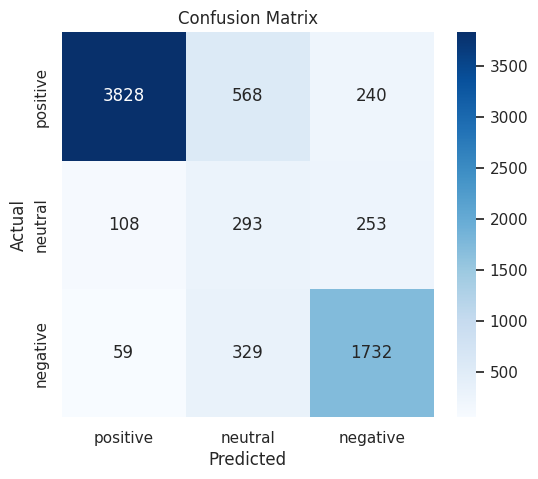

In [169]:
cm = confusion_matrix(y_test, y_pred_cb, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

In [131]:
from transformers import AutoTokenizer, AutoModel
import torch

# Используем BERT для португальского языка
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

text = "produto chegou quebrado e atrasado"

tokenized_text = tokenizer(
    text,
    return_tensors="pt",
)
print(inputs)


{'input_ids': tensor([[  101,  3576,  2080, 19797,   122,  7521,   201,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [132]:
with torch.no_grad():
    output=model(**tokenized_text)
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))
output.last_hidden_state.shape

['[CLS]', 'produto', 'chegou', 'quebrado', 'e', 'atras', '##ado', '[SEP]']


torch.Size([1, 8, 768])

In [133]:
tokenized_text=tokenizer(text)

for key, values in tokenized_text.items():
    values_type =type(values).__name__
    item_type = type(values[0]).__name__
    values_sample =f"[{', '.join(str(value) for value in values[:5])}, ...]"
    print(f"{key}: {values_type}[{item_type}], length {len(values)}: {values_sample}")

input_ids: list[int], length 8: [101, 3576, 2080, 19797, 122, ...]
token_type_ids: list[int], length 8: [0, 0, 0, 0, 0, ...]
attention_mask: list[int], length 8: [1, 1, 1, 1, 1, ...]


In [134]:
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])} ")
print(f"Decoded seuence {tokenizer.decode(tokenized_text['input_ids'])}")

Tokens: ['[CLS]', 'produto', 'chegou', 'quebrado', 'e', 'atras', '##ado', '[SEP]'] 
Decoded seuence [CLS] produto chegou quebrado e atrasado [SEP]


In [135]:
tokenized_texts=tokenizer(df_text['clean_text'].tolist(), return_tensors='pt', padding=True)

for key, values in tokenized_texts.items():
  values_type=type(values).__name__
  print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([37047, 66])
token_type_ids: Tensor, torch.Size([37047, 66])
attention_mask: Tensor, torch.Size([37047, 66])


In [136]:
for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    item_type = type(values[0]).__name__
    print(f"{key}:{values_type}[{item_type}], length{len(values)}")

input_ids:Tensor[Tensor], length37047
token_type_ids:Tensor[Tensor], length37047
attention_mask:Tensor[Tensor], length37047


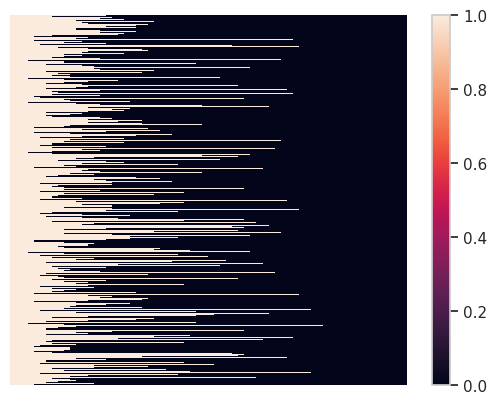

In [137]:
import matplotlib.pyplot as plt

plt.pcolormesh(tokenized_texts["attention_mask"])
plt.axis("off")
plt.colorbar()
plt.show()

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [144]:
texts = df_text['clean_text'].tolist()
labels = df_text['label'].values
batch_size = 32
features = []
with torch.no_grad():
  # Модель энкодера
    for i in range(0, len(texts), batch_size):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        # print(texts_batch.shape)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy() # Берем в каждом сэмпле CLS вектор длиной 768
        features.append(batch_features)


features = np.concatenate(features, axis=0) # Просто качественные эмбеддинги для классификации
features.shape

(37047, 768)

In [145]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [146]:
import warnings
from sklearn.linear_model import LogisticRegression

warnings.simplefilter('ignore')
lr_clf = LogisticRegression().fit(train_features, train_labels)

In [147]:
lr_clf.score(test_features, test_labels)

0.8506801986611963

In [149]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7524


In [152]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

    negative     0.7999    0.7542    0.7764      2120
     neutral     0.2146    0.5443    0.3078       654
    positive     0.9648    0.7808    0.8631      4636

    accuracy                         0.7524      7410
   macro avg     0.6598    0.6931    0.6491      7410
weighted avg     0.8514    0.7524    0.7893      7410



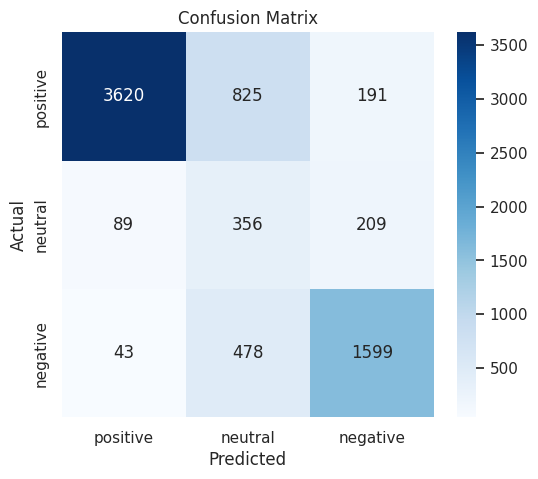

In [153]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

In [154]:
from catboost import CatBoostRegressor

clf_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    class_weights=class_weights,
    verbose=50,
    random_seed=42
)
clf_cb.fit(X_train, y_train)

0:	learn: 1.0511192	total: 126ms	remaining: 1m 2s
50:	learn: 0.6788273	total: 5.23s	remaining: 46s
100:	learn: 0.6289664	total: 10.8s	remaining: 42.5s
150:	learn: 0.5886017	total: 15.6s	remaining: 36s
200:	learn: 0.5517696	total: 20.3s	remaining: 30.2s
250:	learn: 0.5204972	total: 25.9s	remaining: 25.7s
300:	learn: 0.4945360	total: 30.5s	remaining: 20.2s
350:	learn: 0.4692070	total: 36.1s	remaining: 15.3s
400:	learn: 0.4482633	total: 40.8s	remaining: 10.1s
450:	learn: 0.4281829	total: 45.4s	remaining: 4.93s
499:	learn: 0.4117869	total: 51s	remaining: 0us


Accuracy: 0.7873144399460189
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2120
     neutral       0.24      0.45      0.31       654
    positive       0.96      0.82      0.88      4636

    accuracy                           0.79      7410
   macro avg       0.66      0.70      0.67      7410
weighted avg       0.85      0.79      0.81      7410



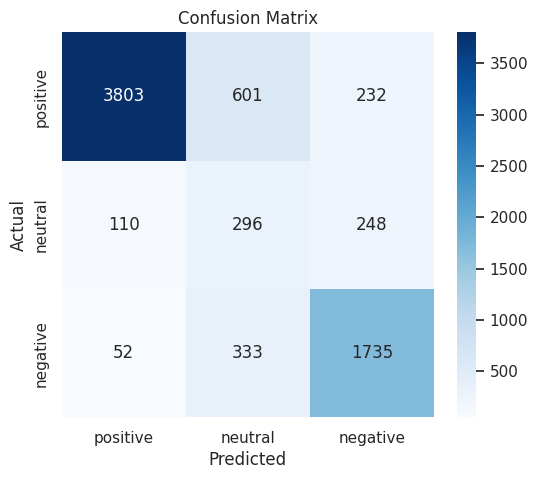

In [155]:
y_pred = clf_cb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

Можно сделать вывод, что CatBoost справился немного лучше, чем логистическая регрессия